In [47]:
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

In [48]:
current_month = datetime.today().month
current_year = datetime.today().year
month_mapping = {1:'jan', 
                 2:'feb',
                 3:'mar', 
                 4:'apr', 
                 5:'may', 
                 6:'jun', 
                 7:'jul', 
                 8:'aug', 
                 9:'sep', 
                 10:'oct', 
                 11:'nov', 
                 12:'dec'}
months = list(month_mapping.values())
current_month_name = month_mapping[current_month]

In [49]:
# Preparing df
LOAD_DIR = Path(Path.cwd(), "data")
tmax_df = pd.read_fwf(Path(LOAD_DIR, 'tmax.txt'))
with open (Path(LOAD_DIR, 'tmax.txt')) as f:
    data = (f.readlines()[5:])
lst_lsts = []
for i in range(len(data)):
    _temp = data[i].split(" ")
    lst_lsts.append([i for i in _temp if i])
df = pd.DataFrame(lst_lsts)

In [50]:
def clean_df(raw_df:pd.DataFrame) -> pd.DataFrame:
    raw_df.columns = raw_df.iloc[0]
    df = raw_df[1:]
    df = df.replace(to_replace = ["---","\n", None], value = np.nan)
    df['ann'] = df['ann\n'].str.replace("\n", "")
    df = df.drop('ann\n', axis = 1, errors = 'ignore')
    df = df.apply(pd.to_numeric)
    return df

df = clean_df(df)

In [51]:
tmax_seasons = df[['win', 'spr', 'sum', 'aut', 'ann']]
df = df.drop(['win', 'spr', 'sum','aut', 'ann'], axis = 1)

In [52]:
# overwriting months not yet occured
months_to_overwrite = []
for i in range(current_month, 13):
    months_to_overwrite.append(month_mapping[i])
for month in months_to_overwrite:
    df.loc[df['year'] == current_year, month] = np.nan

In [53]:
months = df.drop('year', axis = 1).columns.to_list()

In [54]:
tmax_0 = df[months].min()
tmax_10 = df[months].quantile(0.1)
tmax_50 = df[months].quantile(0.5)
tmax_90 = df[months].quantile(0.9)
tmax_100 = df[months].max()

In [55]:
df_quantiles = pd.concat([tmax_0, tmax_10, tmax_50, tmax_90, tmax_100], axis = 1)
df_quantiles = df_quantiles.rename_axis('month')

In [56]:
df_2023 = df[df['year'] == 2023].drop('year', axis = 1)
df_2023

,jan,feb,mar,apr,may,jun,jul,aug,sep,oct,nov,dec
140,7.3,9.0,8.9,11.9,16.2,21.2,18.8,NaN,NaN,NaN,NaN,NaN


In [57]:
def point_style(val, month, deciles_df):
    _min = df_quantiles[df_quantiles.index==month][0.0].values[0]
    _0_1 = df_quantiles[df_quantiles.index==month][0.1].values[0]
    _0_5 = df_quantiles[df_quantiles.index==month][0.5].values[0]
    _0_9 = df_quantiles[df_quantiles.index==month][0.9].values[0]
    _max = df_quantiles[df_quantiles.index==month][1.0].values[0]
    if _min <= val <= _0_1:
        return "^"
    elif _0_1 <= val <= _0_5:
        return "h"
    elif _0_5 <= val <= _0_9:
        return "o"
    elif _0_9 <= val <= _max:
        return "D"
    else:
        return np.nan
    

Text(0.5, 1.0, 'Max Temp')

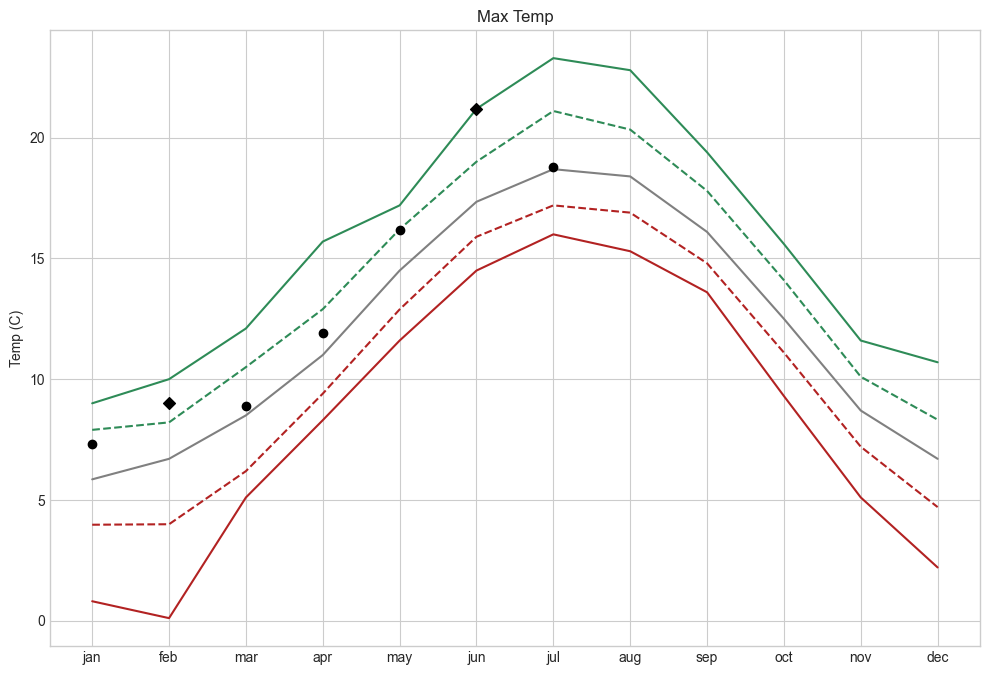

In [58]:
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize = (12,8))
ax.plot(df_quantiles.index, df_quantiles[0.0], c = 'firebrick')
ax.plot(df_quantiles.index, df_quantiles[0.1],  c = 'firebrick', ls = '--')
ax.plot(df_quantiles.index, df_quantiles[0.5], c = 'grey')
ax.plot(df_quantiles.index, df_quantiles[0.9],  c = 'seagreen', ls = '--')
ax.plot(df_quantiles.index, df_quantiles[1.0],  c = 'seagreen')

for month in df_2023.columns:
    if month not in months_to_overwrite:
        val = df_2023[month].values[0]
        ms = point_style(val, month, df_quantiles)
        ax.scatter(month,val, marker = ms, c = 'black', zorder =5)

ax.set_ylabel('Temp (C)')
ax.set_title('Max Temp')